Regression https://www.kaggle.com/datasets/scriptsultan/german-house-prices

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix, f1_score, precision_score
from sklearn.inspection import plot_partial_dependence

import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostClassifier,CatBoostRegressor, Pool, metrics, cv
from lightgbm import plot_importance
from lightgbm import LGBMClassifier, LGBMRegressor

### 2. Regression

In [121]:
data = pd.read_csv('cars.csv')
data.head()

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,mazda,2,5500,2008,with mileage,162000.0,petrol,1500.0,burgundy,mechanics,front-wheel drive,B
1,mazda,2,5350,2009,with mileage,120000.0,petrol,1300.0,black,mechanics,front-wheel drive,B
2,mazda,2,7000,2009,with mileage,61000.0,petrol,1500.0,silver,auto,front-wheel drive,B
3,mazda,2,3300,2003,with mileage,265000.0,diesel,1400.0,white,mechanics,front-wheel drive,B
4,mazda,2,5200,2008,with mileage,97183.0,diesel,1400.0,gray,mechanics,front-wheel drive,B


In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56244 entries, 0 to 56243
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   make                 56244 non-null  object 
 1   model                56244 non-null  object 
 2   priceUSD             56244 non-null  int64  
 3   year                 56244 non-null  int64  
 4   condition            56244 non-null  object 
 5   mileage(kilometers)  56244 non-null  float64
 6   fuel_type            56244 non-null  object 
 7   volume(cm3)          56197 non-null  float64
 8   color                56244 non-null  object 
 9   transmission         56244 non-null  object 
 10  drive_unit           54339 non-null  object 
 11  segment              50953 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 5.1+ MB


In [123]:
data.isnull().sum()

make                      0
model                     0
priceUSD                  0
year                      0
condition                 0
mileage(kilometers)       0
fuel_type                 0
volume(cm3)              47
color                     0
transmission              0
drive_unit             1905
segment                5291
dtype: int64

In [124]:
# na값이 있는 행 제외
data = data.dropna(axis=0).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49223 entries, 0 to 49222
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   make                 49223 non-null  object 
 1   model                49223 non-null  object 
 2   priceUSD             49223 non-null  int64  
 3   year                 49223 non-null  int64  
 4   condition            49223 non-null  object 
 5   mileage(kilometers)  49223 non-null  float64
 6   fuel_type            49223 non-null  object 
 7   volume(cm3)          49223 non-null  float64
 8   color                49223 non-null  object 
 9   transmission         49223 non-null  object 
 10  drive_unit           49223 non-null  object 
 11  segment              49223 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 4.5+ MB


- Target variable distribution

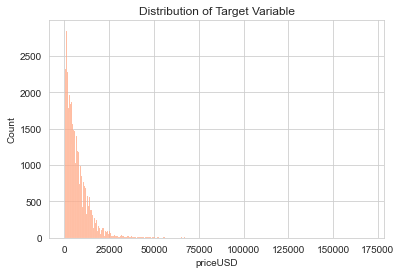

In [125]:
sns.histplot(data['priceUSD'], color="lightsalmon")
plt.title("Distribution of Target Variable");

- Predictor variables

In [126]:
data.columns

Index(['make', 'model', 'priceUSD', 'year', 'condition', 'mileage(kilometers)',
       'fuel_type', 'volume(cm3)', 'color', 'transmission', 'drive_unit',
       'segment'],
      dtype='object')

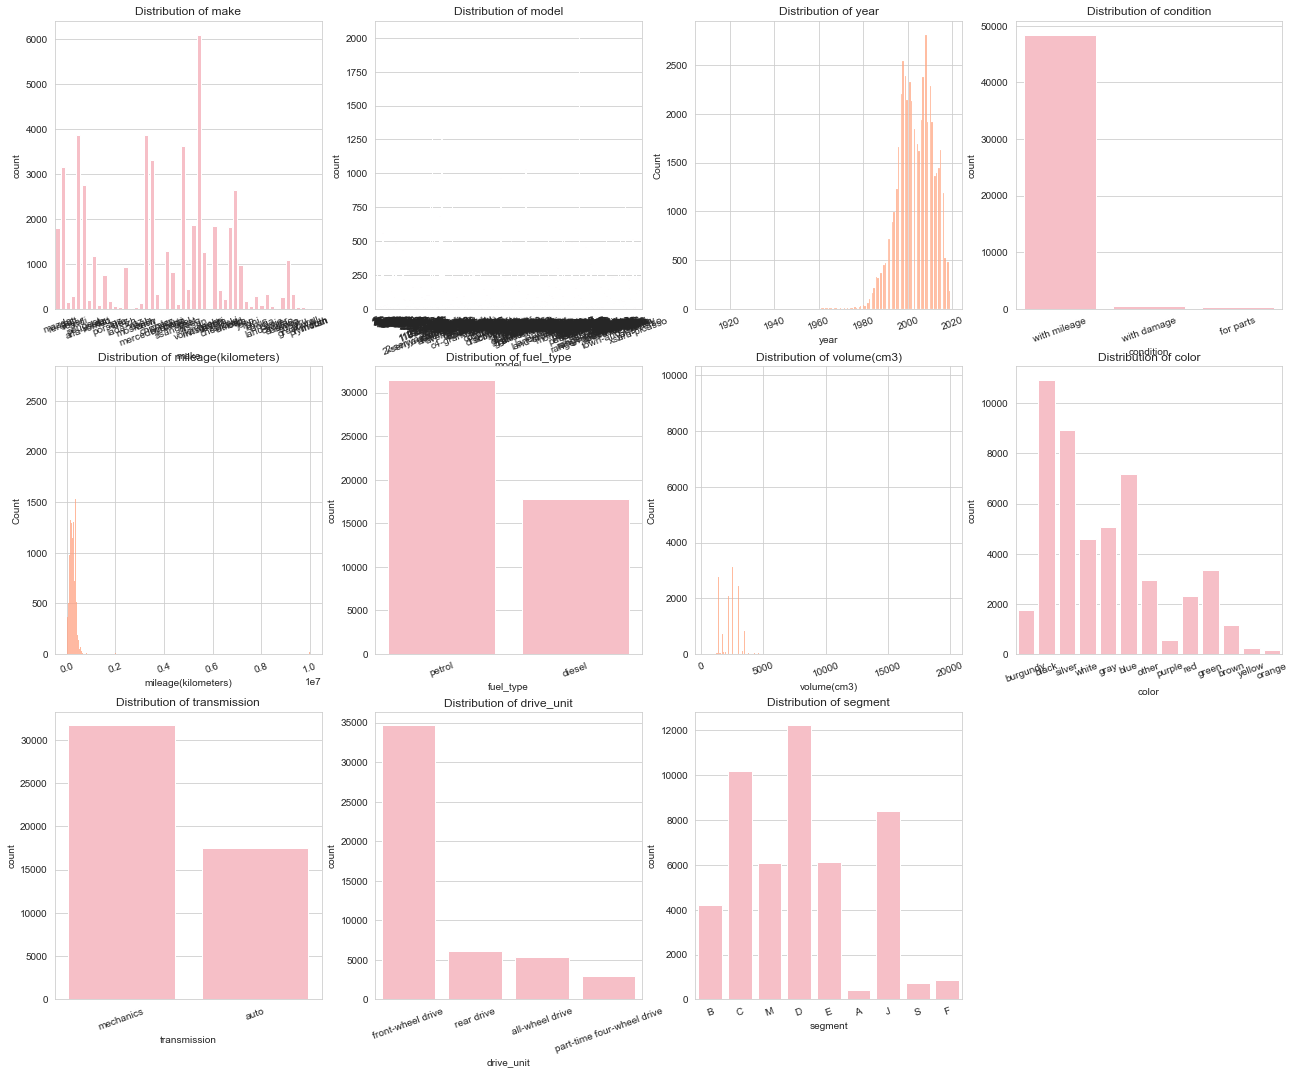

In [127]:
intcols = ['year', 'mileage(kilometers)', 'volume(cm3)']
cols = ['make', 'model', 'year', 'condition', 'mileage(kilometers)',
       'fuel_type', 'volume(cm3)', 'color', 'transmission', 'drive_unit', 'segment']
fig = plt.figure(figsize=(22, 18))
for i in range(len(cols)):
    plt.subplot(3, 4, i+1)
    if cols[i] in intcols:
        sns.histplot(data[cols[i]], color="lightsalmon")
    else:
        sns.countplot(data[cols[i]], color="lightpink")
    plt.title("Distribution of "+cols[i])
    plt.xticks(rotation=20);

In [128]:
for c in data.columns:
    if type(data[c][0]) == str:
        print(data[c].value_counts())

volkswagen       6092
audi             3865
bmw              3858
opel             3610
mercedes-benz    3308
renault          3159
peugeot          2746
ford             2645
nissan           1864
toyota           1840
citroen          1821
mazda            1787
hyundai          1276
mitsubishi       1261
volvo            1164
skoda            1075
kia               976
lada-vaz          926
honda             812
fiat              745
seat              449
chevrolet         414
land-rover        332
subaru            328
chrysler          328
lexus             292
rover             286
daewoo            267
suzuki            210
alfa-romeo        203
porsche           165
jeep              162
gaz               158
saab              119
ssangyong         107
lancia             83
uaz                79
mini               68
dacia              59
zaz                51
great-wall         48
acura              34
luaz               32
moskvich           31
chery              23
cadillac  

범주가 많은 make 변수와 model 변수는 분석에서 제외한다.

In [129]:
data = data.drop(['make', 'model'], axis=1)
data.head()

,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,5500,2008,with mileage,162000.0,petrol,1500.0,burgundy,mechanics,front-wheel drive,B
1,5350,2009,with mileage,120000.0,petrol,1300.0,black,mechanics,front-wheel drive,B
2,7000,2009,with mileage,61000.0,petrol,1500.0,silver,auto,front-wheel drive,B
3,3300,2003,with mileage,265000.0,diesel,1400.0,white,mechanics,front-wheel drive,B
4,5200,2008,with mileage,97183.0,diesel,1400.0,gray,mechanics,front-wheel drive,B


In [130]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
priceUSD,49223.0,7307.665847,7775.309515,48.0,2400.0,5350.0,9750.0,170000.0
year,49223.0,2003.447067,7.917292,1910.0,1998.0,2004.0,2010.0,2019.0
mileage(kilometers),49223.0,248356.801974,320098.879205,0.0,141707.0,232000.0,314000.0,9999999.0
volume(cm3),49223.0,2092.943766,942.335579,500.0,1600.0,1990.0,2300.0,20000.0


- Predictor vs target variable

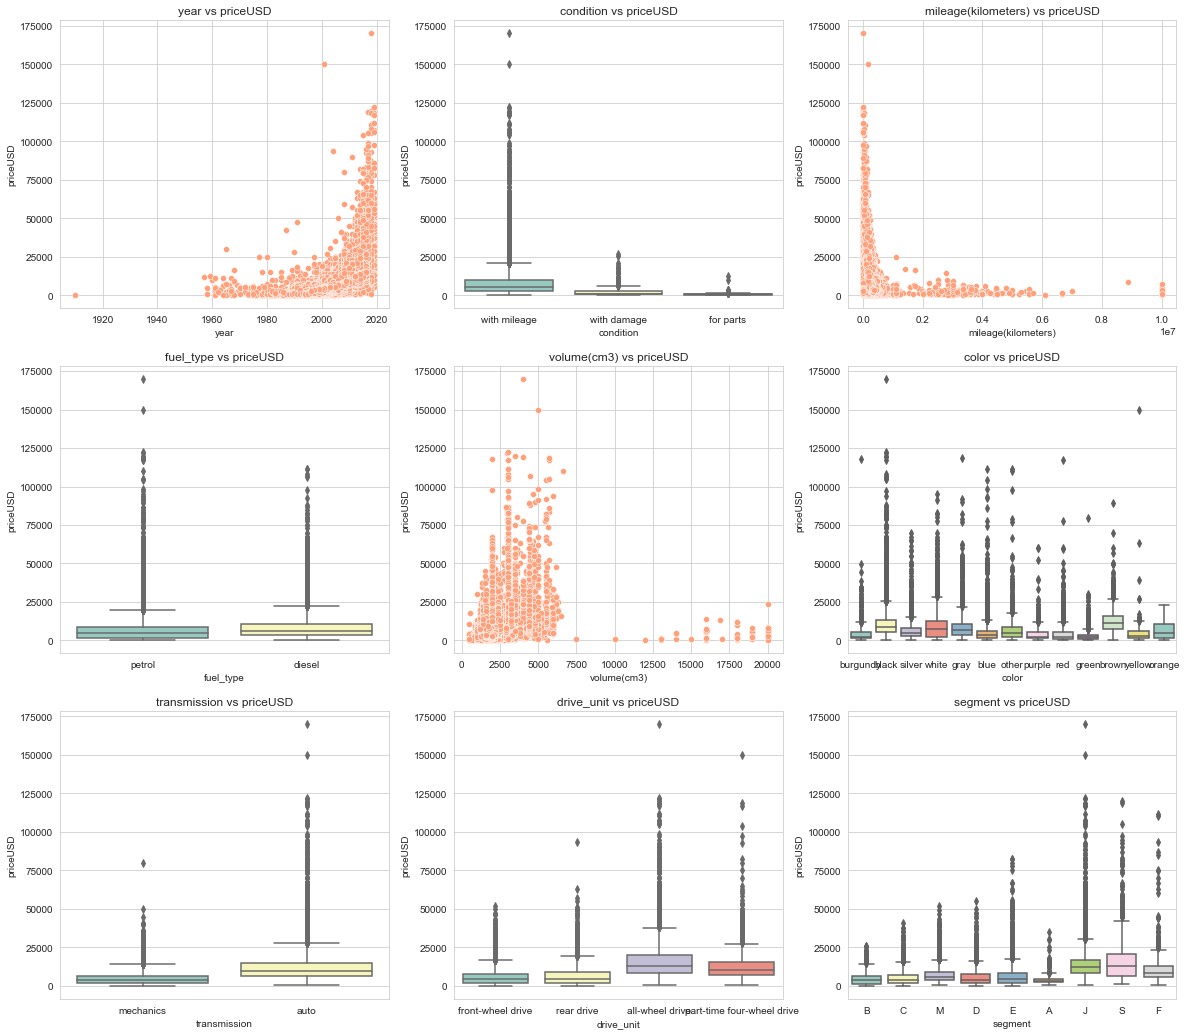

In [131]:
fig = plt.figure(figsize=(20, 18))
for i in range(1, data.shape[1]):
    plt.subplot(3, 3, i)
    if data.columns[i] in intcols:
        sns.scatterplot(x=data.columns[i], y='priceUSD', data=data, color='lightsalmon')
    else:
        sns.boxplot(x=data.columns[i], y='priceUSD', data=data, palette="Set3")
    plt.title(data.columns[i]+" vs priceUSD");

- 수치형 변수들에 대한 correlation plot

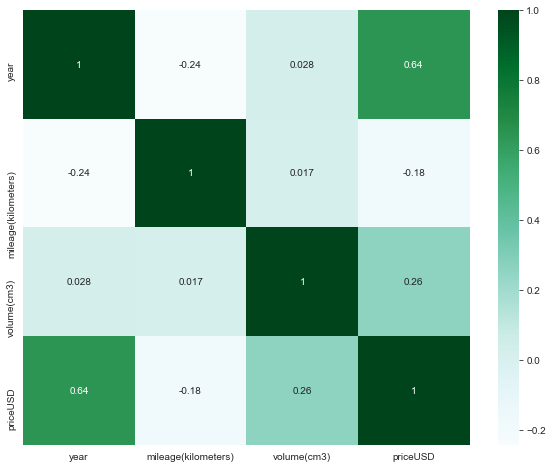

In [132]:
cor = data[['year', 'mileage(kilometers)', 'volume(cm3)', 'priceUSD']].corr()
fig = plt.figure(figsize=(10, 8))
sns.heatmap(cor, annot = True, color = 'blue',  cmap="BuGn");

#### Modeling
- 카테고리형 변수들에 대해 one hot encoding
- 전체 데이터의 70%는 train, 30%는 test set으로 split

In [41]:
X = data.drop(['priceUSD'], axis=1)
y = data['priceUSD']

In [70]:
X1 = pd.get_dummies(X)
train_x, test_x, train_y, test_y = train_test_split(X1, y, test_size=0.3, random_state=777)
train_x.head()

,year,mileage(kilometers),volume(cm3),condition_for parts,condition_with damage,condition_with mileage,fuel_type_diesel,fuel_type_petrol,color_black,color_blue,...,drive_unit_rear drive,segment_A,segment_B,segment_C,segment_D,segment_E,segment_F,segment_J,segment_M,segment_S
16721,2015,155005.0,1560.0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
39167,1991,350000.0,5600.0,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
19390,2009,140000.0,1100.0,0,0,1,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
47250,2008,165000.0,4400.0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
17943,2001,345666.0,2500.0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [43]:
# pseudo-R^2 계산
def getpr2(testy, predy):
    result = 1 - sum((testy - predy)**2) / sum((testy - np.mean(testy))**2)
    return result

In [44]:
# RMSE 계산
def getRMSE(testy, predy):
    return np.sqrt(mean_squared_error(testy, predy))

#### 1) XGBoost

- case 1: 기본 파라미터 사용

In [45]:
start = time.time()
rxgb1 = XGBRegressor(random_state=777)
rxgb1.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))
pred_rxgb1 = rxgb1.predict(test_x)
print(rxgb1.set_params)

실행시간:1.8305668830871582
<bound method XGBModel.set_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=777,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)>


In [46]:
print('RMSE:{}'.format(getRMSE(test_y, pred_rxgb1)))
print('Pseudo-R^2:{}'.format(getpr2(test_y, pred_rxgb1)))

RMSE:2682.006718965501
Pseudo-R^2:0.8859308364595566


In [48]:
test_y.describe()

count     14767.000000
mean       7332.614343
std        7941.278710
min         100.000000
25%        2300.000000
50%        5300.000000
75%        9800.000000
max      121451.000000
Name: priceUSD, dtype: float64

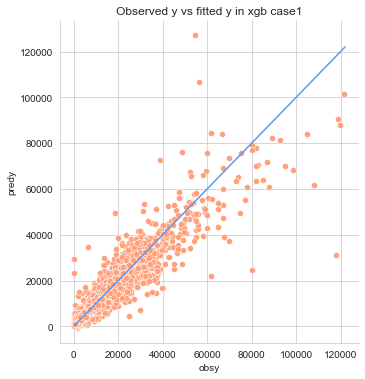

In [49]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_rxgb1})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightsalmon")
plt.plot([100, 122000], [100, 122000], color="cornflowerblue")
plt.title("Observed y vs fitted y in xgb case1");

- case 2: learning rate를 작게, 트리 생성 횟수는 크게 설정

In [50]:
start = time.time()
rxgb2 = XGBRegressor(random_state=777, learning_rate=0.01, n_estimators=1000)
rxgb2.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))
pred_rxgb2 = rxgb2.predict(test_x)

실행시간:13.289822816848755


In [51]:
print('RMSE:{}'.format(getRMSE(test_y, pred_rxgb2)))
print('Pseudo-R^2:{}'.format(getpr2(test_y, pred_rxgb2)))

RMSE:2640.451993447001
Pseudo-R^2:0.8894382037956079


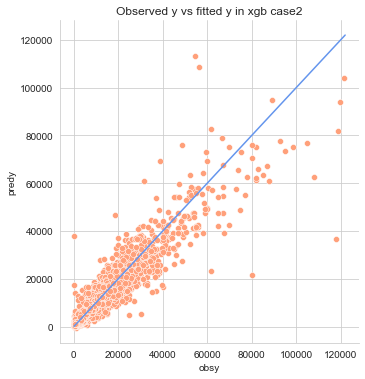

In [53]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_rxgb2})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightsalmon")
plt.plot([100, 122000], [100, 122000], color="cornflowerblue")
plt.title("Observed y vs fitted y in xgb case2");

- case 3: Hyperparameter search

In [64]:
start = time.time()
rxgb3 = XGBRegressor()
xgb_grid = {
    'max_depth':[5, 6, 7],
    'colsample_bytree':[0.6,0.8],
    'gamma': [0.5, 0.75, 1],
    'n_estimators':[700, 1000],
    'learning_rate':[0.01, 0.05, 0.1],
    'random_state':[777]
}
rxgbCV = GridSearchCV(rxgb3, xgb_grid, verbose=2, cv=3)
rxgbCV.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=700, random_state=777; total time=   4.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=700, random_state=777; total time=   4.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=700, random_state=777; total time=   4.5s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=1000, random_state=777; total time=   6.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=1000, random_state=777; total time=   6.5s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=1000, random_state=777; total time=   6.5s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=6, n_estimators=700, random_state=777; total time=   5.7s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=6, n_estimators=1000, random_state=777; total time=   8.2s
[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=6, n_estimators=1000, random_state=777; total time=   8.2s
[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=6, n_estimators=1000, random_state=777; total time=   8.4s
[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=7, n_estimators=700, random_state=777; total time=   7.4s
[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=7, n_estimators=700, random_state=777; total time=   7.3s
[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=7, n_estimators=700, random_state=777; total time=   7.3s
[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=7, n_estimators=1000, random_state=777; total time=  10.4s
[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=7, n_e

[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=700, random_state=777; total time=   3.8s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=700, random_state=777; total time=   4.1s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=700, random_state=777; total time=   3.9s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=1000, random_state=777; total time=   5.6s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=1000, random_state=777; total time=   5.6s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=1000, random_state=777; total time=   5.4s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=700, random_state=777; total time=   4.8s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=700, random_sta

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=1000, random_state=777; total time=   7.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=1000, random_state=777; total time=   7.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=700, random_state=777; total time=   6.9s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=700, random_state=777; total time=   6.5s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=700, random_state=777; total time=   6.4s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=1000, random_state=777; total time=   8.9s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=1000, random_state=777; total time=   9.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimator

[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=5, n_estimators=700, random_state=777; total time=   4.2s
[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=5, n_estimators=700, random_state=777; total time=   4.2s
[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=5, n_estimators=1000, random_state=777; total time=   6.2s
[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=5, n_estimators=1000, random_state=777; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=5, n_estimators=1000, random_state=777; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=6, n_estimators=700, random_state=777; total time=   5.1s
[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=6, n_estimators=700, random_state=777; total time=   5.1s
[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=6, n_estimators

[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=1000, random_state=777; total time=   7.5s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=700, random_state=777; total time=   7.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=700, random_state=777; total time=   6.7s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=700, random_state=777; total time=   6.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=1000, random_state=777; total time=   9.4s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=1000, random_state=777; total time=   9.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=1000, random_state=777; total time=   9.1s
실행시간:2173.396152973175


In [68]:
rxgbCV.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 700,
 'random_state': 777}

In [71]:
start = time.time()
rxgb3 = XGBRegressor(random_state=777, max_depth=5,
                     learning_rate=0.05, gamma=0.5, colsample_bytree=0.6, n_estimators=700)
rxgb3.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))
pred_rxgb3 = rxgb3.predict(test_x)

실행시간:6.090648651123047


In [72]:
print('RMSE:{}'.format(getRMSE(test_y, pred_rxgb3)))
print('Pseudo-R^2:{}'.format(getpr2(test_y, pred_rxgb3)))

RMSE:2724.428536131913
Pseudo-R^2:0.8822937903395652


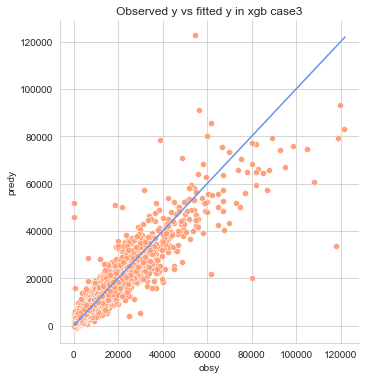

In [73]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_rxgb3})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightsalmon")
plt.plot([100, 122000], [100, 122000], color="cornflowerblue")
plt.title("Observed y vs fitted y in xgb case3");

#### 2) Catboost

In [66]:
intcols

['year', 'mileage(kilometers)', 'volume(cm3)']

- case 1: 기본 파라미터 사용

In [74]:
catcols = list(set(data.columns[1:]) - set(intcols))
for c in catcols:
    X[c] = X[c].astype('category')
    
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=777)
train_x.head()

,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
16721,2015,with mileage,155005.0,diesel,1560.0,gray,mechanics,front-wheel drive,C
39167,1991,with mileage,350000.0,petrol,5600.0,black,auto,rear drive,S
19390,2009,with mileage,140000.0,petrol,1100.0,black,mechanics,front-wheel drive,B
47250,2008,with mileage,165000.0,petrol,4400.0,black,auto,all-wheel drive,J
17943,2001,with mileage,345666.0,diesel,2500.0,other,mechanics,front-wheel drive,M


In [79]:
start = time.time()
rcat1 = CatBoostRegressor(
                          loss_function="RMSE", cat_features=catcols)
rcat1.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))
print(rcat1.get_all_params())

Learning rate set to 0.071625
0:	learn: 7305.8651801	total: 51.1ms	remaining: 51.1s
1:	learn: 6932.5396568	total: 103ms	remaining: 51.6s
2:	learn: 6586.1256747	total: 148ms	remaining: 49.1s
3:	learn: 6278.6667869	total: 198ms	remaining: 49.3s
4:	learn: 5998.4399765	total: 247ms	remaining: 49.1s
5:	learn: 5735.8954252	total: 295ms	remaining: 48.8s
6:	learn: 5501.7116009	total: 356ms	remaining: 50.5s
7:	learn: 5280.7073374	total: 403ms	remaining: 49.9s
8:	learn: 5075.2896311	total: 452ms	remaining: 49.7s
9:	learn: 4881.4146225	total: 499ms	remaining: 49.4s
10:	learn: 4704.8917331	total: 544ms	remaining: 48.9s
11:	learn: 4543.7614651	total: 609ms	remaining: 50.2s
12:	learn: 4396.8036292	total: 660ms	remaining: 50.1s
13:	learn: 4265.9783921	total: 720ms	remaining: 50.7s
14:	learn: 4136.5225580	total: 769ms	remaining: 50.5s
15:	learn: 4020.4586108	total: 815ms	remaining: 50.1s
16:	learn: 3918.0999303	total: 861ms	remaining: 49.8s
17:	learn: 3825.0728974	total: 924ms	remaining: 50.4s
18:	lea

153:	learn: 2455.9698099	total: 7.58s	remaining: 41.6s
154:	learn: 2454.3673832	total: 7.62s	remaining: 41.6s
155:	learn: 2452.2211436	total: 7.67s	remaining: 41.5s
156:	learn: 2452.2114459	total: 7.7s	remaining: 41.3s
157:	learn: 2450.4112105	total: 7.74s	remaining: 41.3s
158:	learn: 2449.1967593	total: 7.79s	remaining: 41.2s
159:	learn: 2449.1888444	total: 7.81s	remaining: 41s
160:	learn: 2448.0689648	total: 7.85s	remaining: 40.9s
161:	learn: 2445.9663105	total: 7.9s	remaining: 40.9s
162:	learn: 2442.9696817	total: 7.94s	remaining: 40.8s
163:	learn: 2442.3077792	total: 7.99s	remaining: 40.7s
164:	learn: 2441.0038746	total: 8.04s	remaining: 40.7s
165:	learn: 2439.8765694	total: 8.11s	remaining: 40.7s
166:	learn: 2437.9641608	total: 8.15s	remaining: 40.7s
167:	learn: 2436.5012444	total: 8.21s	remaining: 40.7s
168:	learn: 2433.9113314	total: 8.26s	remaining: 40.6s
169:	learn: 2431.2899452	total: 8.31s	remaining: 40.6s
170:	learn: 2430.0551696	total: 8.37s	remaining: 40.6s
171:	learn: 24

307:	learn: 2289.7279689	total: 15s	remaining: 33.7s
308:	learn: 2289.5061713	total: 15.1s	remaining: 33.7s
309:	learn: 2287.8972180	total: 15.1s	remaining: 33.7s
310:	learn: 2287.3894075	total: 15.2s	remaining: 33.6s
311:	learn: 2286.9345683	total: 15.2s	remaining: 33.6s
312:	learn: 2286.4281100	total: 15.3s	remaining: 33.5s
313:	learn: 2286.1304745	total: 15.3s	remaining: 33.4s
314:	learn: 2285.6972880	total: 15.3s	remaining: 33.4s
315:	learn: 2285.3424503	total: 15.4s	remaining: 33.3s
316:	learn: 2284.4413969	total: 15.4s	remaining: 33.3s
317:	learn: 2283.1254088	total: 15.5s	remaining: 33.2s
318:	learn: 2283.0517702	total: 15.5s	remaining: 33.2s
319:	learn: 2282.5123530	total: 15.6s	remaining: 33.1s
320:	learn: 2281.2623497	total: 15.6s	remaining: 33.1s
321:	learn: 2280.8570518	total: 15.7s	remaining: 33s
322:	learn: 2280.2673677	total: 15.7s	remaining: 33s
323:	learn: 2278.6276839	total: 15.8s	remaining: 32.9s
324:	learn: 2278.1732087	total: 15.8s	remaining: 32.9s
325:	learn: 2277

459:	learn: 2190.6933530	total: 22.2s	remaining: 26.1s
460:	learn: 2190.5206751	total: 22.3s	remaining: 26.1s
461:	learn: 2188.9200797	total: 22.3s	remaining: 26s
462:	learn: 2188.1206725	total: 22.4s	remaining: 26s
463:	learn: 2187.8777475	total: 22.4s	remaining: 25.9s
464:	learn: 2186.8718911	total: 22.5s	remaining: 25.9s
465:	learn: 2186.6804581	total: 22.5s	remaining: 25.8s
466:	learn: 2185.9129612	total: 22.6s	remaining: 25.8s
467:	learn: 2184.8715980	total: 22.6s	remaining: 25.7s
468:	learn: 2183.8625191	total: 22.7s	remaining: 25.7s
469:	learn: 2183.8432635	total: 22.7s	remaining: 25.6s
470:	learn: 2183.6125451	total: 22.8s	remaining: 25.6s
471:	learn: 2182.6193710	total: 22.8s	remaining: 25.5s
472:	learn: 2182.6119061	total: 22.9s	remaining: 25.5s
473:	learn: 2181.9673364	total: 22.9s	remaining: 25.4s
474:	learn: 2181.4478093	total: 23s	remaining: 25.4s
475:	learn: 2181.2237544	total: 23s	remaining: 25.3s
476:	learn: 2179.6931965	total: 23.1s	remaining: 25.3s
477:	learn: 2179.4

612:	learn: 2112.0107665	total: 29.7s	remaining: 18.8s
613:	learn: 2111.5099566	total: 29.8s	remaining: 18.7s
614:	learn: 2110.9841069	total: 29.8s	remaining: 18.7s
615:	learn: 2110.3788083	total: 29.9s	remaining: 18.6s
616:	learn: 2110.0560609	total: 29.9s	remaining: 18.6s
617:	learn: 2109.4264352	total: 30s	remaining: 18.5s
618:	learn: 2109.0515065	total: 30s	remaining: 18.5s
619:	learn: 2108.3061954	total: 30.1s	remaining: 18.4s
620:	learn: 2107.9292381	total: 30.1s	remaining: 18.4s
621:	learn: 2107.0376997	total: 30.2s	remaining: 18.3s
622:	learn: 2106.8541387	total: 30.2s	remaining: 18.3s
623:	learn: 2106.3044030	total: 30.3s	remaining: 18.2s
624:	learn: 2105.9233835	total: 30.3s	remaining: 18.2s
625:	learn: 2105.6483935	total: 30.4s	remaining: 18.1s
626:	learn: 2104.7329595	total: 30.4s	remaining: 18.1s
627:	learn: 2103.8790513	total: 30.5s	remaining: 18s
628:	learn: 2103.4560874	total: 30.5s	remaining: 18s
629:	learn: 2102.9449151	total: 30.6s	remaining: 18s
630:	learn: 2102.104

764:	learn: 2048.1125550	total: 37.1s	remaining: 11.4s
765:	learn: 2047.8768130	total: 37.1s	remaining: 11.3s
766:	learn: 2047.0882212	total: 37.2s	remaining: 11.3s
767:	learn: 2046.9265904	total: 37.2s	remaining: 11.2s
768:	learn: 2046.7354290	total: 37.3s	remaining: 11.2s
769:	learn: 2046.4313438	total: 37.3s	remaining: 11.1s
770:	learn: 2045.9146593	total: 37.4s	remaining: 11.1s
771:	learn: 2045.7820725	total: 37.4s	remaining: 11s
772:	learn: 2045.7783624	total: 37.4s	remaining: 11s
773:	learn: 2045.6481858	total: 37.5s	remaining: 10.9s
774:	learn: 2045.3873433	total: 37.5s	remaining: 10.9s
775:	learn: 2045.1022070	total: 37.6s	remaining: 10.8s
776:	learn: 2044.7827006	total: 37.7s	remaining: 10.8s
777:	learn: 2043.8241673	total: 37.7s	remaining: 10.8s
778:	learn: 2043.7745467	total: 37.7s	remaining: 10.7s
779:	learn: 2042.9951480	total: 37.8s	remaining: 10.7s
780:	learn: 2042.6912816	total: 37.8s	remaining: 10.6s
781:	learn: 2041.7281251	total: 37.9s	remaining: 10.6s
782:	learn: 20

914:	learn: 1999.6481993	total: 44.7s	remaining: 4.15s
915:	learn: 1999.5444134	total: 44.8s	remaining: 4.1s
916:	learn: 1999.4370644	total: 44.8s	remaining: 4.05s
917:	learn: 1999.2387796	total: 44.9s	remaining: 4.01s
918:	learn: 1999.0661622	total: 44.9s	remaining: 3.96s
919:	learn: 1998.7314799	total: 45s	remaining: 3.91s
920:	learn: 1998.4147644	total: 45s	remaining: 3.86s
921:	learn: 1998.3416233	total: 45.1s	remaining: 3.81s
922:	learn: 1998.0066167	total: 45.1s	remaining: 3.76s
923:	learn: 1997.2922973	total: 45.1s	remaining: 3.71s
924:	learn: 1997.1460996	total: 45.2s	remaining: 3.66s
925:	learn: 1997.1050628	total: 45.2s	remaining: 3.61s
926:	learn: 1996.7386614	total: 45.3s	remaining: 3.56s
927:	learn: 1996.6600031	total: 45.3s	remaining: 3.51s
928:	learn: 1995.8984206	total: 45.4s	remaining: 3.47s
929:	learn: 1995.2612437	total: 45.4s	remaining: 3.42s
930:	learn: 1995.0604977	total: 45.4s	remaining: 3.37s
931:	learn: 1994.7797945	total: 45.5s	remaining: 3.32s
932:	learn: 199

In [80]:
pred_rcat1 = rcat1.predict(test_x)
print('RMSE:{}'.format(getRMSE(test_y, pred_rcat1)))
print('Pseudo-R^2:{}'.format(getpr2(test_y, pred_rcat1)))

RMSE:2591.170358964478
Pseudo-R^2:0.8935267604853294


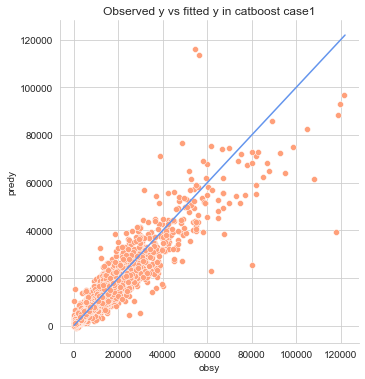

In [84]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_rcat1})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightsalmon")
plt.plot([100, 122000], [100, 122000], color="cornflowerblue")
plt.title("Observed y vs fitted y in catboost case1");

- case 2: learning rate를 작게, 트리 생성 횟수는 크게 설정

In [82]:
start = time.time()
rcat2 = CatBoostRegressor(loss_function="RMSE", cat_features=catcols,
                         learning_rate=0.01, n_estimators=1000)
rcat2.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))

0:	learn: 7647.1267344	total: 45.9ms	remaining: 45.9s
1:	learn: 7590.8357374	total: 91.5ms	remaining: 45.7s
2:	learn: 7534.7036008	total: 138ms	remaining: 45.8s
3:	learn: 7479.1832819	total: 185ms	remaining: 46s
4:	learn: 7426.2456542	total: 231ms	remaining: 45.9s
5:	learn: 7373.2957421	total: 283ms	remaining: 47s
6:	learn: 7321.4461546	total: 329ms	remaining: 46.7s
7:	learn: 7268.6883052	total: 372ms	remaining: 46.1s
8:	learn: 7215.9134869	total: 416ms	remaining: 45.8s
9:	learn: 7164.8784460	total: 456ms	remaining: 45.1s
10:	learn: 7113.1778583	total: 494ms	remaining: 44.4s
11:	learn: 7062.6574278	total: 535ms	remaining: 44.1s
12:	learn: 7013.1016387	total: 593ms	remaining: 45s
13:	learn: 6964.1407313	total: 637ms	remaining: 44.9s
14:	learn: 6914.5573493	total: 686ms	remaining: 45.1s
15:	learn: 6866.1306488	total: 744ms	remaining: 45.7s
16:	learn: 6819.2093271	total: 804ms	remaining: 46.5s
17:	learn: 6771.8956817	total: 865ms	remaining: 47.2s
18:	learn: 6725.3338087	total: 911ms	remai

155:	learn: 3591.1595209	total: 8.01s	remaining: 43.4s
156:	learn: 3581.5353657	total: 8.06s	remaining: 43.3s
157:	learn: 3572.6973166	total: 8.11s	remaining: 43.2s
158:	learn: 3564.0675410	total: 8.15s	remaining: 43.1s
159:	learn: 3555.0328739	total: 8.2s	remaining: 43s
160:	learn: 3545.7422625	total: 8.25s	remaining: 43s
161:	learn: 3537.2483060	total: 8.3s	remaining: 42.9s
162:	learn: 3528.5629268	total: 8.35s	remaining: 42.9s
163:	learn: 3519.7585856	total: 8.4s	remaining: 42.8s
164:	learn: 3511.5331278	total: 8.45s	remaining: 42.8s
165:	learn: 3503.0958137	total: 8.5s	remaining: 42.7s
166:	learn: 3494.7131480	total: 8.54s	remaining: 42.6s
167:	learn: 3486.2577597	total: 8.59s	remaining: 42.6s
168:	learn: 3478.5090075	total: 8.64s	remaining: 42.5s
169:	learn: 3470.6140916	total: 8.7s	remaining: 42.5s
170:	learn: 3462.6492908	total: 8.75s	remaining: 42.4s
171:	learn: 3454.9884202	total: 8.8s	remaining: 42.4s
172:	learn: 3447.2269148	total: 8.85s	remaining: 42.3s
173:	learn: 3439.695

307:	learn: 2905.3370510	total: 15.5s	remaining: 34.8s
308:	learn: 2903.2128575	total: 15.5s	remaining: 34.7s
309:	learn: 2901.2395996	total: 15.6s	remaining: 34.7s
310:	learn: 2899.4200515	total: 15.6s	remaining: 34.6s
311:	learn: 2896.8362448	total: 15.7s	remaining: 34.6s
312:	learn: 2895.0021270	total: 15.7s	remaining: 34.5s
313:	learn: 2892.9854720	total: 15.8s	remaining: 34.4s
314:	learn: 2891.4857085	total: 15.8s	remaining: 34.4s
315:	learn: 2889.2811172	total: 15.9s	remaining: 34.3s
316:	learn: 2887.4508476	total: 15.9s	remaining: 34.3s
317:	learn: 2885.3511523	total: 16s	remaining: 34.2s
318:	learn: 2883.2963767	total: 16s	remaining: 34.2s
319:	learn: 2881.4990661	total: 16.1s	remaining: 34.1s
320:	learn: 2879.8465619	total: 16.1s	remaining: 34.1s
321:	learn: 2878.3463822	total: 16.2s	remaining: 34.1s
322:	learn: 2876.4208508	total: 16.2s	remaining: 34s
323:	learn: 2875.1301568	total: 16.3s	remaining: 34s
324:	learn: 2873.0515026	total: 16.3s	remaining: 33.9s
325:	learn: 2871.3

458:	learn: 2714.0515992	total: 23.1s	remaining: 27.2s
459:	learn: 2713.2324726	total: 23.1s	remaining: 27.2s
460:	learn: 2712.0984671	total: 23.2s	remaining: 27.1s
461:	learn: 2711.5229893	total: 23.2s	remaining: 27s
462:	learn: 2710.6532058	total: 23.3s	remaining: 27s
463:	learn: 2709.7364256	total: 23.3s	remaining: 26.9s
464:	learn: 2709.0216064	total: 23.4s	remaining: 26.9s
465:	learn: 2708.2095269	total: 23.4s	remaining: 26.8s
466:	learn: 2707.4815816	total: 23.5s	remaining: 26.8s
467:	learn: 2706.9085967	total: 23.5s	remaining: 26.7s
468:	learn: 2705.8447846	total: 23.5s	remaining: 26.6s
469:	learn: 2704.8520812	total: 23.6s	remaining: 26.6s
470:	learn: 2703.9266088	total: 23.6s	remaining: 26.5s
471:	learn: 2703.2925953	total: 23.6s	remaining: 26.5s
472:	learn: 2702.4758788	total: 23.7s	remaining: 26.4s
473:	learn: 2701.9158737	total: 23.7s	remaining: 26.3s
474:	learn: 2701.0546409	total: 23.8s	remaining: 26.3s
475:	learn: 2700.5883620	total: 23.8s	remaining: 26.2s
476:	learn: 26

610:	learn: 2612.7479307	total: 30.3s	remaining: 19.3s
611:	learn: 2612.5681514	total: 30.4s	remaining: 19.3s
612:	learn: 2611.7586288	total: 30.4s	remaining: 19.2s
613:	learn: 2610.9384540	total: 30.5s	remaining: 19.2s
614:	learn: 2610.5592006	total: 30.5s	remaining: 19.1s
615:	learn: 2609.8263289	total: 30.6s	remaining: 19.1s
616:	learn: 2609.2379023	total: 30.6s	remaining: 19s
617:	learn: 2608.7652848	total: 30.7s	remaining: 19s
618:	learn: 2608.3312197	total: 30.7s	remaining: 18.9s
619:	learn: 2608.0670526	total: 30.8s	remaining: 18.9s
620:	learn: 2607.5198788	total: 30.8s	remaining: 18.8s
621:	learn: 2606.8766274	total: 30.9s	remaining: 18.8s
622:	learn: 2606.0190439	total: 30.9s	remaining: 18.7s
623:	learn: 2605.5111009	total: 31s	remaining: 18.7s
624:	learn: 2604.9497435	total: 31s	remaining: 18.6s
625:	learn: 2604.2201539	total: 31.1s	remaining: 18.6s
626:	learn: 2603.6352243	total: 31.1s	remaining: 18.5s
627:	learn: 2603.0115324	total: 31.2s	remaining: 18.5s
628:	learn: 2602.6

763:	learn: 2546.2845273	total: 37.9s	remaining: 11.7s
764:	learn: 2545.8703981	total: 38s	remaining: 11.7s
765:	learn: 2545.3723014	total: 38s	remaining: 11.6s
766:	learn: 2545.0361012	total: 38.1s	remaining: 11.6s
767:	learn: 2544.6879273	total: 38.1s	remaining: 11.5s
768:	learn: 2544.3937409	total: 38.2s	remaining: 11.5s
769:	learn: 2544.0638611	total: 38.2s	remaining: 11.4s
770:	learn: 2543.6801881	total: 38.2s	remaining: 11.4s
771:	learn: 2543.5089419	total: 38.3s	remaining: 11.3s
772:	learn: 2543.0392911	total: 38.3s	remaining: 11.3s
773:	learn: 2542.6214997	total: 38.4s	remaining: 11.2s
774:	learn: 2542.3453552	total: 38.5s	remaining: 11.2s
775:	learn: 2542.0840498	total: 38.5s	remaining: 11.1s
776:	learn: 2541.6449660	total: 38.6s	remaining: 11.1s
777:	learn: 2541.4163066	total: 38.6s	remaining: 11s
778:	learn: 2540.8352912	total: 38.7s	remaining: 11s
779:	learn: 2540.6033639	total: 38.7s	remaining: 10.9s
780:	learn: 2540.3530148	total: 38.8s	remaining: 10.9s
781:	learn: 2540.0

916:	learn: 2496.5681857	total: 45.2s	remaining: 4.09s
917:	learn: 2496.2488793	total: 45.2s	remaining: 4.04s
918:	learn: 2496.2461842	total: 45.3s	remaining: 3.99s
919:	learn: 2496.0306865	total: 45.3s	remaining: 3.94s
920:	learn: 2495.7142515	total: 45.4s	remaining: 3.89s
921:	learn: 2495.5107617	total: 45.4s	remaining: 3.84s
922:	learn: 2495.1724137	total: 45.5s	remaining: 3.79s
923:	learn: 2494.7782914	total: 45.5s	remaining: 3.75s
924:	learn: 2494.5172896	total: 45.6s	remaining: 3.7s
925:	learn: 2494.2048537	total: 45.6s	remaining: 3.65s
926:	learn: 2494.0335220	total: 45.7s	remaining: 3.6s
927:	learn: 2493.3101596	total: 45.7s	remaining: 3.55s
928:	learn: 2493.1766699	total: 45.8s	remaining: 3.5s
929:	learn: 2492.7981339	total: 45.8s	remaining: 3.45s
930:	learn: 2492.3381383	total: 45.9s	remaining: 3.4s
931:	learn: 2492.0487045	total: 45.9s	remaining: 3.35s
932:	learn: 2491.6358421	total: 46s	remaining: 3.3s
933:	learn: 2491.4452907	total: 46s	remaining: 3.25s
934:	learn: 2491.25

In [83]:
pred_rcat2 = rcat2.predict(test_x)
print('RMSE:{}'.format(getRMSE(test_y, pred_rcat2)))
print('Pseudo-R^2:{}'.format(getpr2(test_y, pred_rcat2)))

RMSE:2691.676679141495
Pseudo-R^2:0.8851068021490601


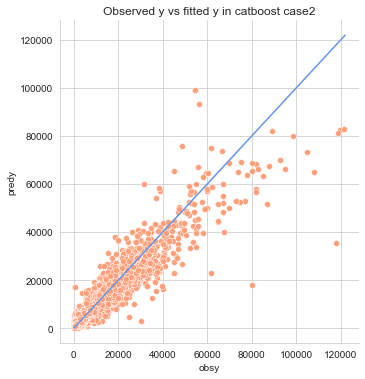

In [85]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_rcat2})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightsalmon")
plt.plot([100, 122000], [100, 122000], color="cornflowerblue")
plt.title("Observed y vs fitted y in catboost case2");

- case 3: Hyperparameter search

In [89]:
start = time.time()
cat3 = CatBoostRegressor(
    boosting_type="Plain",
    random_state=777,
    loss_function='RMSE',
    cat_features=catcols,
    verbose=500
)

cat_grid = {'learning_rate': [0.01,0.05,0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.1, 1, 3],
        'iterations':[500, 1000],
        'border_count':[64,254],
        'rsm':[0.85, 1]
        }

grid_search_result = cat3.grid_search(cat_grid, X=train_x, y=train_y, plot=True)
print("실행시간:{}".format(time.time()-start))
grid_search_result

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 10469.2517633	test: 10726.9927967	best: 10726.9927967 (0)	total: 26.1ms	remaining: 13s
499:	learn: 2787.9965309	test: 3268.5611776	best: 3268.5611776 (499)	total: 15.2s	remaining: 0us

bestTest = 3268.561178
bestIteration = 499

0:	loss: 3268.5611776	best: 3268.5611776 (0)	total: 15.3s	remaining: 54m 51s
0:	learn: 10114.4961711	test: 10369.4117039	best: 10369.4117039 (0)	total: 26.6ms	remaining: 13.3s
499:	learn: 2360.0716365	test: 3058.6044375	best: 3058.6044375 (499)	total: 15.6s	remaining: 0us

bestTest = 3058.604437
bestIteration = 499

1:	loss: 3058.6044375	best: 3058.6044375 (1)	total: 30.9s	remaining: 55m 8s
0:	learn: 9674.6408333	test: 9926.4933344	best: 9926.4933344 (0)	total: 27.9ms	remaining: 13.9s
499:	learn: 2224.9240273	test: 2995.2055680	best: 2995.2055680 (499)	total: 15.5s	remaining: 0us

bestTest = 2995.205568
bestIteration = 499

2:	loss: 2995.2055680	best: 2995.2055680 (2)	total: 46.4s	remaining: 54m 56s
0:	learn: 10469.3621447	test: 10727.1065307	best: 10

499:	learn: 1957.4633436	test: 2944.3956997	best: 2943.9084917 (493)	total: 24.7s	remaining: 0us

bestTest = 2943.908492
bestIteration = 493

23:	loss: 2943.9084917	best: 2916.0864642 (11)	total: 9m 34s	remaining: 1h 16m 39s
0:	learn: 10469.2775938	test: 10726.9049773	best: 10726.9049773 (0)	total: 44.3ms	remaining: 22.1s
499:	learn: 2609.9122659	test: 3160.2515886	best: 3160.2515886 (499)	total: 24.4s	remaining: 0us

bestTest = 3160.251589
bestIteration = 499

24:	loss: 3160.2515886	best: 2916.0864642 (11)	total: 9m 59s	remaining: 1h 16m 19s
0:	learn: 10114.5563999	test: 10368.9153721	best: 10368.9153721 (0)	total: 39.5ms	remaining: 19.7s
499:	learn: 2195.0232565	test: 2997.6779312	best: 2997.6779312 (499)	total: 24.9s	remaining: 0us

bestTest = 2997.677931
bestIteration = 499

25:	loss: 2997.6779312	best: 2916.0864642 (11)	total: 10m 24s	remaining: 1h 16m 2s
0:	learn: 9674.5747856	test: 9925.3464353	best: 9925.3464353 (0)	total: 39.7ms	remaining: 19.8s
499:	learn: 2019.1046278	test: 

500:	learn: 1811.0496021	test: 2928.9287027	best: 2928.9287027 (500)	total: 33s	remaining: 32.8s
999:	learn: 1601.4285537	test: 2900.8218367	best: 2898.6178671 (953)	total: 1m 7s	remaining: 0us

bestTest = 2898.617867
bestIteration = 953

46:	loss: 2898.6178671	best: 2898.6178671 (46)	total: 24m 54s	remaining: 1h 29m 35s
0:	learn: 9652.8167408	test: 9901.5230909	best: 9901.5230909 (0)	total: 74.9ms	remaining: 1m 14s
500:	learn: 1612.0473901	test: 2989.1602912	best: 2985.3440922 (337)	total: 34.2s	remaining: 34s
999:	learn: 1400.0634875	test: 2992.4089564	best: 2985.3440922 (337)	total: 1m 5s	remaining: 0us

bestTest = 2985.344092
bestIteration = 337

47:	loss: 2985.3440922	best: 2898.6178671 (46)	total: 26m	remaining: 1h 31m 2s
0:	learn: 10467.6689343	test: 10725.0848183	best: 10725.0848183 (0)	total: 56.7ms	remaining: 56.7s
500:	learn: 2375.5399497	test: 3056.8330130	best: 3056.8330130 (500)	total: 32.9s	remaining: 32.7s
999:	learn: 2161.5486727	test: 2997.6053876	best: 2997.6053876 (

500:	learn: 2239.3310733	test: 3000.0394433	best: 2998.5950011 (496)	total: 19.2s	remaining: 19.1s
999:	learn: 2063.5038899	test: 2960.7589106	best: 2960.7589106 (999)	total: 39s	remaining: 0us

bestTest = 2960.758911
bestIteration = 999

68:	loss: 2960.7589106	best: 2898.6178671 (46)	total: 41m 48s	remaining: 1h 29m 4s
0:	learn: 10472.0893328	test: 10729.3364731	best: 10729.3364731 (0)	total: 27.7ms	remaining: 27.7s
500:	learn: 2822.2038259	test: 3296.7980645	best: 3296.7980645 (500)	total: 18.4s	remaining: 18.3s
999:	learn: 2606.3202033	test: 3163.7491789	best: 3163.7491789 (999)	total: 36.5s	remaining: 0us

bestTest = 3163.749179
bestIteration = 999

69:	loss: 3163.7491789	best: 2898.6178671 (46)	total: 42m 25s	remaining: 1h 28m 28s
0:	learn: 10128.7895821	test: 10381.2067383	best: 10381.2067383 (0)	total: 32.9ms	remaining: 32.9s
500:	learn: 2445.1189619	test: 3067.9749162	best: 3067.9066238 (497)	total: 19s	remaining: 19s
999:	learn: 2299.8326402	test: 3017.8087352	best: 3017.80873

499:	learn: 2325.0497888	test: 3052.1958248	best: 3052.1309025 (498)	total: 31.5s	remaining: 0us

bestTest = 3052.130902
bestIteration = 498

90:	loss: 3052.1309025	best: 2880.6869793 (89)	total: 54m 49s	remaining: 1h 15m 18s
0:	learn: 10101.2826272	test: 10354.4363388	best: 10354.4363388 (0)	total: 57.6ms	remaining: 28.7s
499:	learn: 1809.5157921	test: 2941.8170925	best: 2941.1200969 (497)	total: 32.2s	remaining: 0us

bestTest = 2941.120097
bestIteration = 497

91:	loss: 2941.1200969	best: 2880.6869793 (89)	total: 55m 21s	remaining: 1h 14m 36s
0:	learn: 9647.6871221	test: 9896.1265471	best: 9896.1265471 (0)	total: 50ms	remaining: 25s
499:	learn: 1602.4419984	test: 2990.8806198	best: 2987.7039581 (488)	total: 32.5s	remaining: 0us

bestTest = 2987.703958
bestIteration = 488

92:	loss: 2987.7039581	best: 2880.6869793 (89)	total: 55m 53s	remaining: 1h 13m 55s
0:	learn: 10467.1617457	test: 10724.4700288	best: 10724.4700288 (0)	total: 60.9ms	remaining: 30.4s
499:	learn: 2367.1516572	test: 3

499:	learn: 2219.0366289	test: 2999.8082766	best: 2999.4432794 (486)	total: 16.8s	remaining: 0us

bestTest = 2999.443279
bestIteration = 486

113:	loss: 2999.4432794	best: 2880.6869793 (89)	total: 1h 10m 52s	remaining: 1h 3m 25s
0:	learn: 10469.3821083	test: 10727.6098785	best: 10727.6098785 (0)	total: 54.5ms	remaining: 27.2s
499:	learn: 2820.6899924	test: 3293.1355685	best: 3293.1355685 (499)	total: 16.9s	remaining: 0us

bestTest = 3293.135568
bestIteration = 499

114:	loss: 3293.1355685	best: 2880.6869793 (89)	total: 1h 11m 9s	remaining: 1h 2m 30s
0:	learn: 10115.1201728	test: 10372.4829656	best: 10372.4829656 (0)	total: 30.1ms	remaining: 15s
499:	learn: 2419.9277139	test: 3057.8893172	best: 3057.8893172 (499)	total: 17s	remaining: 0us

bestTest = 3057.889317
bestIteration = 499

115:	loss: 3057.8893172	best: 2880.6869793 (89)	total: 1h 11m 26s	remaining: 1h 1m 35s
0:	learn: 9675.8133821	test: 9932.5951478	best: 9932.5951478 (0)	total: 19.5ms	remaining: 9.73s
499:	learn: 2260.5839344

500:	learn: 2046.3473304	test: 2993.9393957	best: 2993.9393957 (500)	total: 23.9s	remaining: 23.8s
999:	learn: 1873.2541308	test: 2944.4658604	best: 2944.3976579 (983)	total: 49.8s	remaining: 0us

bestTest = 2944.397658
bestIteration = 983

136:	loss: 2944.3976579	best: 2880.6869793 (89)	total: 1h 21m 28s	remaining: 46m 59s
0:	learn: 9652.5752489	test: 9914.9211814	best: 9914.9211814 (0)	total: 38.5ms	remaining: 38.4s
500:	learn: 1867.6584988	test: 2931.4213896	best: 2931.4213896 (500)	total: 24.8s	remaining: 24.7s
999:	learn: 1668.4330473	test: 2915.3941856	best: 2912.4385845 (853)	total: 49.8s	remaining: 0us

bestTest = 2912.438584
bestIteration = 853

137:	loss: 2912.4385845	best: 2880.6869793 (89)	total: 1h 22m 18s	remaining: 46m 31s
0:	learn: 10467.5302304	test: 10726.2512746	best: 10726.2512746 (0)	total: 76ms	remaining: 1m 15s
500:	learn: 2564.1213998	test: 3145.0348998	best: 3145.0168000 (499)	total: 25.4s	remaining: 25.3s
999:	learn: 2351.7004210	test: 3052.8347509	best: 3052.

500:	learn: 1671.4407958	test: 2968.0152374	best: 2964.2574580 (423)	total: 35.1s	remaining: 34.9s
999:	learn: 1458.4236764	test: 2970.7223669	best: 2962.7512319 (740)	total: 1m 10s	remaining: 0us

bestTest = 2962.751232
bestIteration = 740

158:	loss: 2962.7512319	best: 2880.6869793 (89)	total: 1h 39m 39s	remaining: 35m 43s
0:	learn: 10468.0813374	test: 10726.3940426	best: 10726.3940426 (0)	total: 67.4ms	remaining: 1m 7s
500:	learn: 2416.8279292	test: 3088.1856947	best: 3088.1856947 (500)	total: 36.1s	remaining: 36s
999:	learn: 2221.3182686	test: 3024.1740872	best: 3024.1740872 (999)	total: 1m 10s	remaining: 0us

bestTest = 3024.174087
bestIteration = 999

159:	loss: 3024.1740872	best: 2880.6869793 (89)	total: 1h 40m 49s	remaining: 35m 17s
0:	learn: 10108.3507529	test: 10366.0943751	best: 10366.0943751 (0)	total: 71.4ms	remaining: 1m 11s
500:	learn: 1970.1207255	test: 2974.1673823	best: 2974.1673823 (500)	total: 34.8s	remaining: 34.6s
999:	learn: 1773.6995254	test: 2946.3500265	best: 

499:	learn: 2524.0191388	test: 3121.6867583	best: 3121.6867583 (499)	total: 26.7s	remaining: 0us

bestTest = 3121.686758
bestIteration = 499

180:	loss: 3121.6867583	best: 2880.6869793 (89)	total: 1h 51m 23s	remaining: 21m 32s
0:	learn: 10103.8031329	test: 10357.7967378	best: 10357.7967378 (0)	total: 54.5ms	remaining: 27.2s
499:	learn: 2042.3492947	test: 2963.5646369	best: 2963.1979683 (497)	total: 27.7s	remaining: 0us

bestTest = 2963.197968
bestIteration = 497

181:	loss: 2963.1979683	best: 2880.6869793 (89)	total: 1h 51m 51s	remaining: 20m 53s
0:	learn: 9652.8348882	test: 9903.0296230	best: 9903.0296230 (0)	total: 50.8ms	remaining: 25.3s
499:	learn: 1864.3437840	test: 2895.7308628	best: 2895.7308628 (499)	total: 30.1s	remaining: 0us

bestTest = 2895.730863
bestIteration = 499

182:	loss: 2895.7308628	best: 2880.6869793 (89)	total: 1h 52m 21s	remaining: 20m 15s
0:	learn: 10467.4970397	test: 10725.0685392	best: 10725.0685392 (0)	total: 36.9ms	remaining: 18.4s
499:	learn: 2550.3718201	

499:	learn: 1662.0713862	test: 2936.5796237	best: 2936.5796237 (499)	total: 36.4s	remaining: 0us

bestTest = 2936.579624
bestIteration = 499

203:	loss: 2936.5796237	best: 2873.3089466 (191)	total: 2h 6m 12s	remaining: 7m 25s
0:	learn: 10467.4910649	test: 10725.2060656	best: 10725.2060656 (0)	total: 57.6ms	remaining: 28.7s
499:	learn: 2422.6336014	test: 3087.4170312	best: 3087.4170312 (499)	total: 35.9s	remaining: 0us

bestTest = 3087.417031
bestIteration = 499

204:	loss: 3087.4170312	best: 2873.3089466 (191)	total: 2h 6m 48s	remaining: 6m 48s
0:	learn: 10105.4356726	test: 10360.2712925	best: 10360.2712925 (0)	total: 61.9ms	remaining: 30.9s
499:	learn: 1968.8611268	test: 2981.8037701	best: 2981.7588566 (493)	total: 35.2s	remaining: 0us

bestTest = 2981.758857
bestIteration = 493

205:	loss: 2981.7588566	best: 2873.3089466 (191)	total: 2h 7m 23s	remaining: 6m 11s
0:	learn: 9655.8300746	test: 9907.6604747	best: 9907.6604747 (0)	total: 124ms	remaining: 1m 1s
499:	learn: 1765.8550219	test

{'params': {'border_count': 254,
  'rsm': 1,
  'depth': 8,
  'iterations': 1000,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,

In [90]:
start = time.time()
rcat3 = CatBoostRegressor(loss_function="RMSE", cat_features=catcols,
                         border_count=254, rsm=1, depth=8,
                         iterations=1000, learning_rate=0.1, l2_leaf_reg=0.1)
rcat3.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))

0:	learn: 7115.5027756	total: 48.4ms	remaining: 48.3s
1:	learn: 6588.7067051	total: 98.1ms	remaining: 49s
2:	learn: 6123.1111158	total: 150ms	remaining: 49.7s
3:	learn: 5711.6143245	total: 229ms	remaining: 57s
4:	learn: 5351.0781179	total: 290ms	remaining: 57.6s
5:	learn: 5018.4448017	total: 340ms	remaining: 56.3s
6:	learn: 4734.2366695	total: 389ms	remaining: 55.2s
7:	learn: 4478.5675282	total: 450ms	remaining: 55.8s
8:	learn: 4243.7444633	total: 502ms	remaining: 55.3s
9:	learn: 4049.2754896	total: 554ms	remaining: 54.8s
10:	learn: 3876.4290575	total: 603ms	remaining: 54.2s
11:	learn: 3719.1523026	total: 654ms	remaining: 53.8s
12:	learn: 3588.1311905	total: 712ms	remaining: 54.1s
13:	learn: 3470.2532854	total: 765ms	remaining: 53.9s
14:	learn: 3361.8208973	total: 817ms	remaining: 53.7s
15:	learn: 3270.8316280	total: 867ms	remaining: 53.3s
16:	learn: 3192.4334187	total: 918ms	remaining: 53.1s
17:	learn: 3121.2747226	total: 985ms	remaining: 53.7s
18:	learn: 3055.2800767	total: 1.05s	rem

152:	learn: 2018.9282557	total: 8.52s	remaining: 47.2s
153:	learn: 2016.3333775	total: 8.58s	remaining: 47.1s
154:	learn: 2015.3554991	total: 8.64s	remaining: 47.1s
155:	learn: 2013.4961102	total: 8.69s	remaining: 47s
156:	learn: 2011.6589812	total: 8.74s	remaining: 46.9s
157:	learn: 2010.3213825	total: 8.8s	remaining: 46.9s
158:	learn: 2008.9016119	total: 8.85s	remaining: 46.8s
159:	learn: 2005.4671684	total: 8.9s	remaining: 46.7s
160:	learn: 2004.3555694	total: 8.96s	remaining: 46.7s
161:	learn: 2001.0652675	total: 9.01s	remaining: 46.6s
162:	learn: 2000.0827009	total: 9.07s	remaining: 46.6s
163:	learn: 1997.8820036	total: 9.12s	remaining: 46.5s
164:	learn: 1995.3096239	total: 9.18s	remaining: 46.4s
165:	learn: 1993.2384224	total: 9.23s	remaining: 46.4s
166:	learn: 1991.4222425	total: 9.28s	remaining: 46.3s
167:	learn: 1988.1799146	total: 9.34s	remaining: 46.3s
168:	learn: 1987.1074015	total: 9.4s	remaining: 46.2s
169:	learn: 1986.1723401	total: 9.45s	remaining: 46.1s
170:	learn: 198

303:	learn: 1819.5972638	total: 17.6s	remaining: 40.2s
304:	learn: 1818.0273323	total: 17.7s	remaining: 40.3s
305:	learn: 1816.0979345	total: 17.8s	remaining: 40.3s
306:	learn: 1815.7626373	total: 17.9s	remaining: 40.3s
307:	learn: 1815.1366350	total: 17.9s	remaining: 40.3s
308:	learn: 1813.2079765	total: 18s	remaining: 40.3s
309:	learn: 1812.1289726	total: 18.1s	remaining: 40.3s
310:	learn: 1810.9413562	total: 18.2s	remaining: 40.2s
311:	learn: 1810.7233593	total: 18.2s	remaining: 40.2s
312:	learn: 1808.8177861	total: 18.3s	remaining: 40.1s
313:	learn: 1808.0930113	total: 18.3s	remaining: 40s
314:	learn: 1806.6907456	total: 18.4s	remaining: 40s
315:	learn: 1806.2161066	total: 18.4s	remaining: 39.9s
316:	learn: 1804.6678035	total: 18.5s	remaining: 39.8s
317:	learn: 1804.2156592	total: 18.5s	remaining: 39.8s
318:	learn: 1803.5038289	total: 18.6s	remaining: 39.7s
319:	learn: 1800.9467214	total: 18.6s	remaining: 39.6s
320:	learn: 1800.2936678	total: 18.7s	remaining: 39.6s
321:	learn: 1799

454:	learn: 1695.2636884	total: 26.1s	remaining: 31.3s
455:	learn: 1694.6399050	total: 26.2s	remaining: 31.3s
456:	learn: 1693.5623587	total: 26.3s	remaining: 31.2s
457:	learn: 1692.7828236	total: 26.3s	remaining: 31.1s
458:	learn: 1691.8019127	total: 26.4s	remaining: 31.1s
459:	learn: 1690.9707232	total: 26.4s	remaining: 31s
460:	learn: 1689.9235304	total: 26.5s	remaining: 31s
461:	learn: 1689.0125660	total: 26.5s	remaining: 30.9s
462:	learn: 1688.8143326	total: 26.6s	remaining: 30.8s
463:	learn: 1687.6443941	total: 26.6s	remaining: 30.8s
464:	learn: 1686.7718210	total: 26.7s	remaining: 30.7s
465:	learn: 1685.9900850	total: 26.7s	remaining: 30.6s
466:	learn: 1685.3960595	total: 26.8s	remaining: 30.6s
467:	learn: 1685.1622043	total: 26.8s	remaining: 30.5s
468:	learn: 1684.2303797	total: 26.9s	remaining: 30.4s
469:	learn: 1683.3698235	total: 26.9s	remaining: 30.4s
470:	learn: 1682.8765326	total: 27s	remaining: 30.3s
471:	learn: 1682.3656683	total: 27.1s	remaining: 30.3s
472:	learn: 1682

605:	learn: 1604.6454719	total: 34.6s	remaining: 22.5s
606:	learn: 1604.1406710	total: 34.7s	remaining: 22.5s
607:	learn: 1603.8259018	total: 34.8s	remaining: 22.4s
608:	learn: 1603.4527272	total: 34.8s	remaining: 22.4s
609:	learn: 1602.9355326	total: 34.9s	remaining: 22.3s
610:	learn: 1602.1390550	total: 35s	remaining: 22.3s
611:	learn: 1600.8686740	total: 35s	remaining: 22.2s
612:	learn: 1599.9281548	total: 35.1s	remaining: 22.2s
613:	learn: 1599.6465022	total: 35.2s	remaining: 22.1s
614:	learn: 1599.4102208	total: 35.3s	remaining: 22.1s
615:	learn: 1598.6242738	total: 35.3s	remaining: 22s
616:	learn: 1597.8085651	total: 35.4s	remaining: 22s
617:	learn: 1597.0804656	total: 35.4s	remaining: 21.9s
618:	learn: 1596.8472549	total: 35.5s	remaining: 21.9s
619:	learn: 1596.5170832	total: 35.6s	remaining: 21.8s
620:	learn: 1595.7131530	total: 35.6s	remaining: 21.7s
621:	learn: 1595.3843259	total: 35.7s	remaining: 21.7s
622:	learn: 1594.7610769	total: 35.7s	remaining: 21.6s
623:	learn: 1593.7

758:	learn: 1531.0616920	total: 43.6s	remaining: 13.8s
759:	learn: 1530.7130155	total: 43.7s	remaining: 13.8s
760:	learn: 1529.8812328	total: 43.8s	remaining: 13.7s
761:	learn: 1529.6058249	total: 43.8s	remaining: 13.7s
762:	learn: 1529.3317039	total: 43.9s	remaining: 13.6s
763:	learn: 1529.0796566	total: 44s	remaining: 13.6s
764:	learn: 1528.4002917	total: 44s	remaining: 13.5s
765:	learn: 1528.3429827	total: 44.1s	remaining: 13.5s
766:	learn: 1527.7558050	total: 44.1s	remaining: 13.4s
767:	learn: 1527.4075447	total: 44.2s	remaining: 13.3s
768:	learn: 1525.6363265	total: 44.3s	remaining: 13.3s
769:	learn: 1525.3629309	total: 44.3s	remaining: 13.2s
770:	learn: 1525.1285282	total: 44.4s	remaining: 13.2s
771:	learn: 1524.7508775	total: 44.4s	remaining: 13.1s
772:	learn: 1524.4982161	total: 44.5s	remaining: 13.1s
773:	learn: 1523.8302304	total: 44.5s	remaining: 13s
774:	learn: 1523.4552607	total: 44.6s	remaining: 12.9s
775:	learn: 1522.6980032	total: 44.6s	remaining: 12.9s
776:	learn: 1522

911:	learn: 1474.8848137	total: 52.2s	remaining: 5.04s
912:	learn: 1474.6143126	total: 52.3s	remaining: 4.98s
913:	learn: 1474.5017581	total: 52.4s	remaining: 4.93s
914:	learn: 1473.7214626	total: 52.4s	remaining: 4.87s
915:	learn: 1473.2777648	total: 52.5s	remaining: 4.81s
916:	learn: 1472.8315952	total: 52.5s	remaining: 4.75s
917:	learn: 1472.5519458	total: 52.6s	remaining: 4.7s
918:	learn: 1472.4368277	total: 52.6s	remaining: 4.64s
919:	learn: 1472.0728730	total: 52.7s	remaining: 4.58s
920:	learn: 1471.7115179	total: 52.8s	remaining: 4.53s
921:	learn: 1471.5994760	total: 52.8s	remaining: 4.47s
922:	learn: 1471.2209094	total: 52.9s	remaining: 4.41s
923:	learn: 1471.0132454	total: 52.9s	remaining: 4.35s
924:	learn: 1470.6053262	total: 53s	remaining: 4.29s
925:	learn: 1470.1181122	total: 53.1s	remaining: 4.24s
926:	learn: 1470.0114197	total: 53.1s	remaining: 4.18s
927:	learn: 1469.8209793	total: 53.2s	remaining: 4.12s
928:	learn: 1469.2128812	total: 53.2s	remaining: 4.07s
929:	learn: 1

In [91]:
pred_rcat3 = rcat3.predict(test_x)
print('RMSE:{}'.format(getRMSE(test_y, pred_rcat3)))
print('Pseudo-R^2:{}'.format(getpr2(test_y, pred_rcat3)))

RMSE:2608.40686548519
Pseudo-R^2:0.8921055257452902


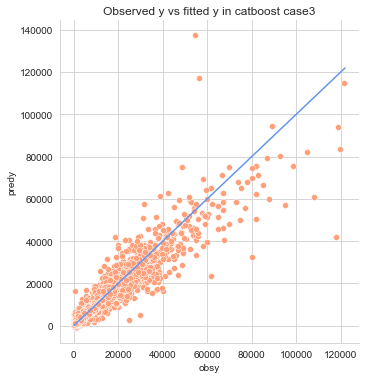

In [92]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_rcat3})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightsalmon")
plt.plot([100, 122000], [100, 122000], color="cornflowerblue")
plt.title("Observed y vs fitted y in catboost case3");

#### 3) LightGBM

In [142]:
train_x, test_x, train_y, test_y = train_test_split(X1, y, test_size=0.3, random_state=777)
train_x.head()

,year,mileage(kilometers),volume(cm3),condition_for parts,condition_with damage,condition_with mileage,fuel_type_diesel,fuel_type_petrol,color_black,color_blue,...,drive_unit_rear drive,segment_A,segment_B,segment_C,segment_D,segment_E,segment_F,segment_J,segment_M,segment_S
16721,2015,155005.0,1560.0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
39167,1991,350000.0,5600.0,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
19390,2009,140000.0,1100.0,0,0,1,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
47250,2008,165000.0,4400.0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
17943,2001,345666.0,2500.0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


- case 1: 기본 파라미터 사용

In [99]:
rlgbm1 = LGBMRegressor(random_state=777)

start = time.time()
rlgbm1.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))
pred_rlgbm1 = rlgbm1.predict(test_x)

실행시간:0.18155479431152344


In [100]:
pred_rlgbm1 = rlgbm1.predict(test_x)
print('RMSE:{}'.format(getRMSE(test_y, pred_rlgbm1)))
print('Pseudo-R^2:{}'.format(getpr2(test_y, pred_rlgbm1)))

RMSE:2641.367500316726
Pseudo-R^2:0.8893615217488248


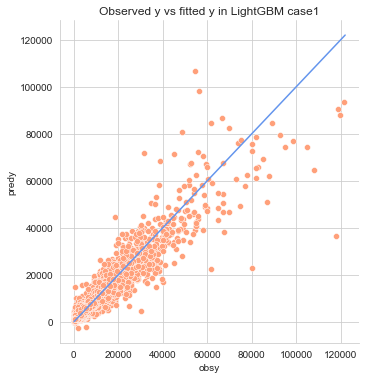

In [101]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_rlgbm1})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightsalmon")
plt.plot([100, 122000], [100, 122000], color="cornflowerblue")
plt.title("Observed y vs fitted y in LightGBM case1");

- case2: learning rate를 작게, 트리 생성 횟수는 크게 설정

In [102]:
rlgbm2 = LGBMRegressor(random_state=777,
                      learning_rate=0.01, n_estimators=1000)

start = time.time()
rlgbm2.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))
pred_rlgbm2 = rlgbm2.predict(test_x)

실행시간:1.51674222946167


In [103]:
print('RMSE:{}'.format(getRMSE(test_y, pred_rlgbm2)))
print('Pseudo-R^2:{}'.format(getpr2(test_y, pred_rlgbm2)))

RMSE:2634.5482978976606
Pseudo-R^2:0.8899320537009798


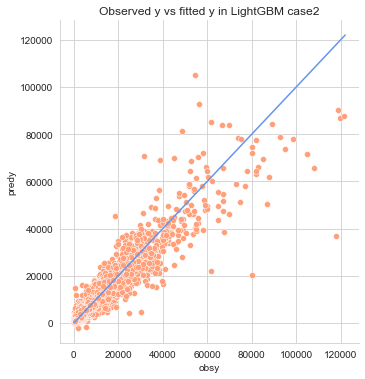

In [104]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_rlgbm2})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightsalmon")
plt.plot([100, 122000], [100, 122000], color="cornflowerblue")
plt.title("Observed y vs fitted y in LightGBM case2");

- case3: Hyperparameter tuning

In [105]:
start = time.time()
lgbm3 = LGBMRegressor(random_state=777)
lgbm_grid = {
    'num_leaves':[10,20],
    'max_depth':[-1,4, 6],
    "min_data":[500, 750, 1000],
    'max_bin':[255,512],
    'learning_rate':[0.01, 0.05, 0.1],
    'n_estimators':[500, 1000]

}
lgbmCV = GridSearchCV(lgbm3, lgbm_grid, verbose=-1, cv=3)
lgbmCV.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_l

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_da

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_l

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: 

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_l

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_dat

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_l

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: 

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_l

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: m

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_l

In [106]:
lgbmCV.best_params_

{'learning_rate': 0.1,
 'max_bin': 255,
 'max_depth': -1,
 'min_data': 500,
 'n_estimators': 1000,
 'num_leaves': 20}

In [143]:
rlgbm3 = LGBMRegressor(random_state=777,
                      learning_rate=0.1, max_bin=255, max_depth=-1,
                       min_data=500, n_estimators=1000, num_leaves=20)

start = time.time()
rlgbm3.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))
pred_rlgbm3 = rlgbm3.predict(test_x)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
실행시간:1.0029411315917969


In [108]:
print('RMSE:{}'.format(getRMSE(test_y, pred_rlgbm3)))
print('Pseudo-R^2:{}'.format(getpr2(test_y, pred_rlgbm3)))

RMSE:2700.506687976654
Pseudo-R^2:0.884351754561223


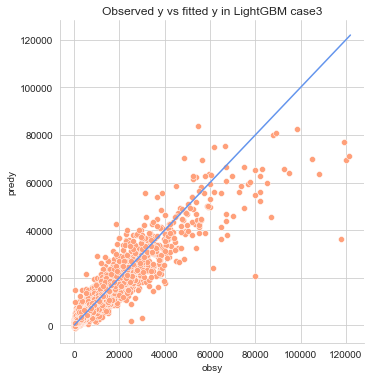

In [109]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_rlgbm3})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightsalmon")
plt.plot([100, 122000], [100, 122000], color="cornflowerblue")
plt.title("Observed y vs fitted y in LightGBM case3");

#### Best model: Catboost case 1

In [145]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=777)

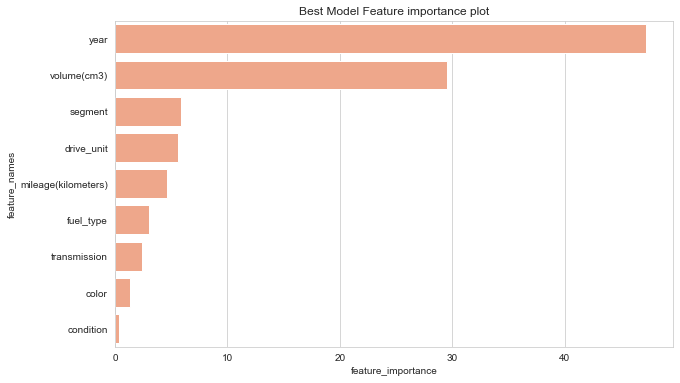

In [137]:
## Feature importance plot
temp = pd.DataFrame({'feature_importance': rcat1.get_feature_importance(), 
              'feature_names': train_x.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False).iloc[:15]

fig = plt.figure(figsize=(10, 6))
sns.barplot(x='feature_importance', y='feature_names', data=temp, color="lightsalmon")
plt.title("Best Model Feature importance plot");

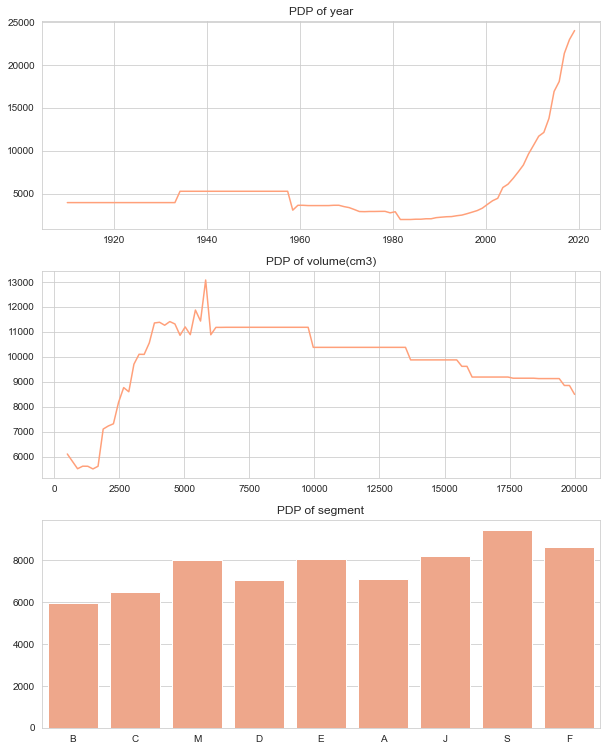

In [146]:
pdpcols = ['year', 'volume(cm3)', 'segment']
plt.figure(figsize=(10, 13))
for n in range(len(pdpcols)):
    tmp = train_x.copy()
    if pdpcols[n] == 'segment':
        idx = list(data[pdpcols[n]].unique())
        results = []
        for i in idx:
            tmp.loc[:, pdpcols[n]] = i
            result = rcat1.predict(tmp)
            results.append(np.mean(result))
        results = np.array(results)
        plt.subplot(3, 1, n+1)
        sns.barplot(x=idx, y=results, color="lightsalmon")
        plt.title("PDP of "+pdpcols[n]);
    else:
        idx = np.linspace(min(tmp.loc[:, pdpcols[n]]), max(tmp.loc[:, pdpcols[n]]), 100)
        results = []
        for i in idx:
            tmp.loc[:, pdpcols[n]] = i
            result = rcat1.predict(tmp)
            results.append(np.mean(result))
    
        results = np.array(results)
        plt.subplot(3, 1, n+1)
        sns.lineplot(x=idx, y=results, color="lightsalmon")
        plt.title("PDP of "+pdpcols[n]);